 ## Recommender Systems: Collaborative Filtering

In [1]:
import pandas as pd


In [2]:

names = ['userid', 'itemid', 'rating','id','user_id','item_id' ]
df = pd.read_csv('/Users/jyothi/Desktop/Movie/out.csv', sep=',', names=names ,low_memory=False)
df.tail()

,userid,itemid,rating,id,user_id,item_id
500095,2870,3952,4,2870_3952,88,3551
500096,2872,3952,4,2872_3952,90,3551
500097,2882,3952,4,2882_3952,100,3551
500098,3942,3952,2,3942_3952,1157,3551
500099,5359,3952,5,5359_3952,2574,3551


In [3]:
df.head()

,userid,itemid,rating,id,user_id,item_id
0,2787,1,5,2787_1,5,1
1,2788,1,5,2788_1,6,1
2,2792,1,3,2792_1,10,1
3,2796,1,3,2796_1,14,1
4,2799,1,5,2799_1,17,1


In [4]:
import matplotlib.pyplot as plt 

## Histograms  -- Ratings,  User and Item

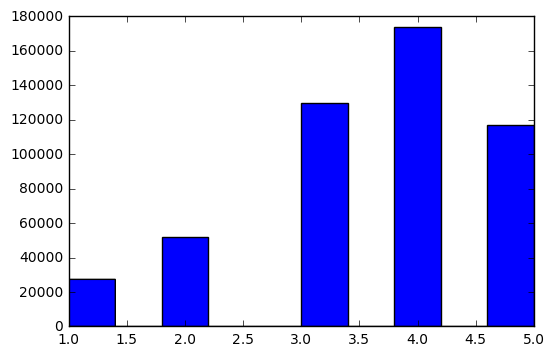

In [5]:
plt.hist(df['rating'])
plt.show()

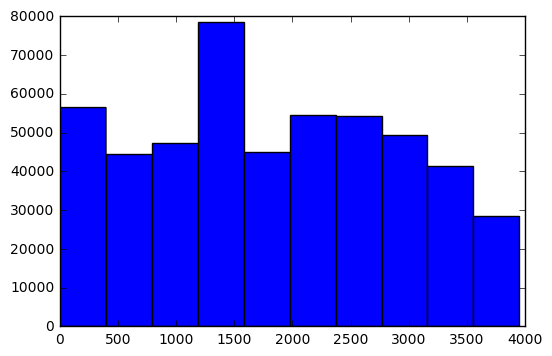

In [6]:
plt.hist(df['itemid'])
plt.show()

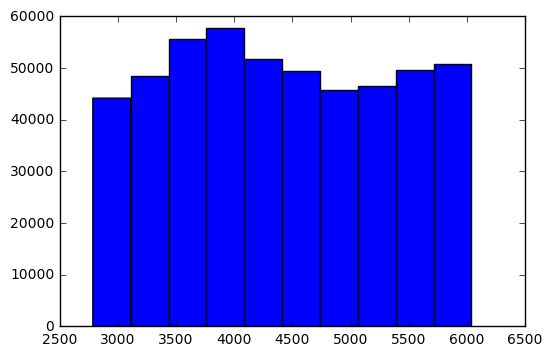

In [7]:
plt.hist(df['userid'])
plt.show()

In [8]:
n_users = df.userid.unique().shape[0]
n_users

3255

## Creating Matrix

In [18]:
df.userid.max()

6040

In [19]:
df.itemid.max()

3952

In [9]:

n_items = df['itemid'].unique().shape[ 0]
n_items

3551

In [20]:
import numpy as np
ratings = np.zeros((df.userid.max(), df.itemid.max()))
for row in df.itertuples():
    ratings[row[5]-1, row[ 6]-1] = row[3]

In [21]:
ratings.shape

(6040, 3952)

## Find the Sparsity of Matrix 

In [26]:
import sklearn

In [39]:
#ratings = np.zeros((6040, 3952))

In [27]:
ratings.shape

(6040, 3952)

In [28]:
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  3., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 3.,  0.,  0., ...,  0.,  0.,  0.]])

## This means that 4.18% of the user-item ratings have a valu

In [29]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print( 'Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 4.18%


### Splitting into Train and test. We will split our data into training and test sets by removing 10 ratings per user from the training set and placing them in the test set.

In [30]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [31]:
train, test = train_test_split(ratings)

### Sparsity of Train and Test 

In [32]:
sparsity = float(len(train.nonzero()[0]))
sparsity /= (train.shape[0] * train.shape[1])
sparsity *= 100
print( 'Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 3.94%


In [33]:
sparsity = float(len(test.nonzero()[0]))
sparsity /= (test.shape[0] * test.shape[1])
sparsity *= 100
print( 'Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.24%


## Find Similarity Matrix

In [34]:
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [35]:
%timeit fast_similarity(train, kind='user')

1 loop, best of 3: 4.26 s per loop


In [36]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
print ( item_similarity[:4, :4])

[[ 1.          0.38154536  0.26671636  0.18585992]
 [ 0.38154536  1.          0.27086287  0.15864703]
 [ 0.26671636  0.27086287  1.          0.2331957 ]
 [ 0.18585992  0.15864703  0.2331957   1.        ]]


In [37]:
user_similarity

array([[  1.00000000e+00,   3.91522151e-12,   1.91358561e-02, ...,
          3.04897888e-12,   1.44484737e-02,   2.01997061e-02],
       [  3.91522151e-12,   1.00000000e+00,   2.59976270e-12, ...,
          8.28457481e-12,   2.45367930e-12,   1.56816882e-12],
       [  1.91358561e-02,   2.59976270e-12,   1.00000000e+00, ...,
          7.28843505e-02,   3.53778448e-02,   6.32322044e-02],
       ..., 
       [  3.04897888e-12,   8.28457481e-12,   7.28843505e-02, ...,
          1.00000000e+00,   1.22291381e-01,   8.18211720e-02],
       [  1.44484737e-02,   2.45367930e-12,   3.53778448e-02, ...,
          1.22291381e-01,   1.00000000e+00,   2.00377167e-01],
       [  2.01997061e-02,   1.56816882e-12,   6.32322044e-02, ...,
          8.18211720e-02,   2.00377167e-01,   1.00000000e+00]])

In [38]:
item_similarity

array([[  1.00000000e+00,   3.81545356e-01,   2.66716365e-01, ...,
          1.67753597e-07,   1.67753597e-07,   4.96668537e-02],
       [  3.81545356e-01,   1.00000000e+00,   2.70862868e-01, ...,
          3.60164561e-07,   3.60164561e-07,   2.43495009e-02],
       [  2.66716365e-01,   2.70862868e-01,   1.00000000e+00, ...,
          5.50148560e-07,   5.50148560e-07,   1.28254044e-12],
       ..., 
       [  1.67753597e-07,   3.60164561e-07,   5.50148560e-07, ...,
          1.00000000e+00,   1.00000000e+00,   2.33126202e-06],
       [  1.67753597e-07,   3.60164561e-07,   5.50148560e-07, ...,
          1.00000000e+00,   1.00000000e+00,   2.33126202e-06],
       [  4.96668537e-02,   2.43495009e-02,   1.28254044e-12, ...,
          2.33126202e-06,   2.33126202e-06,   1.00000000e+00]])

## Predict unknown ratings of each user 

In [39]:
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [40]:
%timeit predict_fast_simple(train, user_similarity, kind='user')

1 loop, best of 3: 5.34 s per loop


In [41]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

## Find MSE for User and  Item predictions. 

In [42]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print ('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print ('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 10.2596788122
Item-based CF MSE: 12.9836130054


### Item Based Filtering is less efficient than User based Filtering

In [43]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

## Now predict Ratings from top K users ratings. Here we are using Top 40 Users

In [44]:
user_pred = predict_topk(train, user_similarity, kind='user', k=40)
print ('Top-k User-based CF MSE: ' + str(get_mse(user_pred, test)))

item_pred = predict_topk(train, item_similarity, kind='item', k=40)
print ('Top-k Item-based CF MSE: ' + str(get_mse(item_pred, test)))

Top-k User-based CF MSE: 7.38381441793
Top-k Item-based CF MSE: 8.88503342012


## Now MSE is lesser than previous prection.(Finding rating with total users and Top 40 users) 

In [60]:
user_pred

array([[ 0.29943031,  0.08756301,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.22327907,  0.        ,  0.08158382, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.17245671,  0.6988156 ,  1.44712669, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.7041948 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.04696772,  0.47015519,  0.22574728, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.577271  ,  0.69195197,  0.1209941 , ...,  0.        ,
         0.        ,  0.        ]])

In [61]:
item_pred

array([[ 0.42626596,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.18666071,  0.17927339,  1.72634466, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.86905362,  0.30642731,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.19570044,  0.18135941,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [45]:

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

## Now we try to find best K value 

In [46]:
user_train_mse =[]
user_test_mse=[]
item_train_mse =[]
item_test_mse=[]

In [47]:

user_train_mse  += [get_mse(user_pred, train)]
user_test_mse   += [get_mse(user_pred, test)]


In [48]:

item_train_mse  += [get_mse(item_pred, train)]
item_test_mse   += [get_mse(item_pred, test)]

In [49]:
user_test_mse

[7.3838144179282086]

In [50]:
user_train_mse

[4.3288052799705046]

In [51]:
item_test_mse

[8.8850334201162529]

In [52]:
item_train_mse

[4.6808910485969673]

In [62]:
user_train_mse =[]
user_test_mse=[]
item_train_mse =[]
item_test_mse=[]
k_array = [5,15, 30, 50]
for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]

## MSE values for k - 5,15, 30 , 50 

In [63]:

user_train_mse

[1.9752069495714824,
 3.4123285396368503,
 4.0859070092084062,
 4.5081987040878877]

In [64]:
user_test_mse

[9.6490481846797032,
 8.0196801829844979,
 7.5215498869530597,
 7.3017715238345833]

In [65]:
k_array = [5,15, 30, 50]
for k in k_array:
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]

In [66]:
item_train_mse

[2.0298085644746084, 3.5889731419831725, 4.378313913605365, 4.9097232627326575]

In [67]:
item_test_mse

[9.6777407018528674,
 8.7584064718465839,
 8.7724962621564604,
 9.0007304037218816]

## Plot the values 

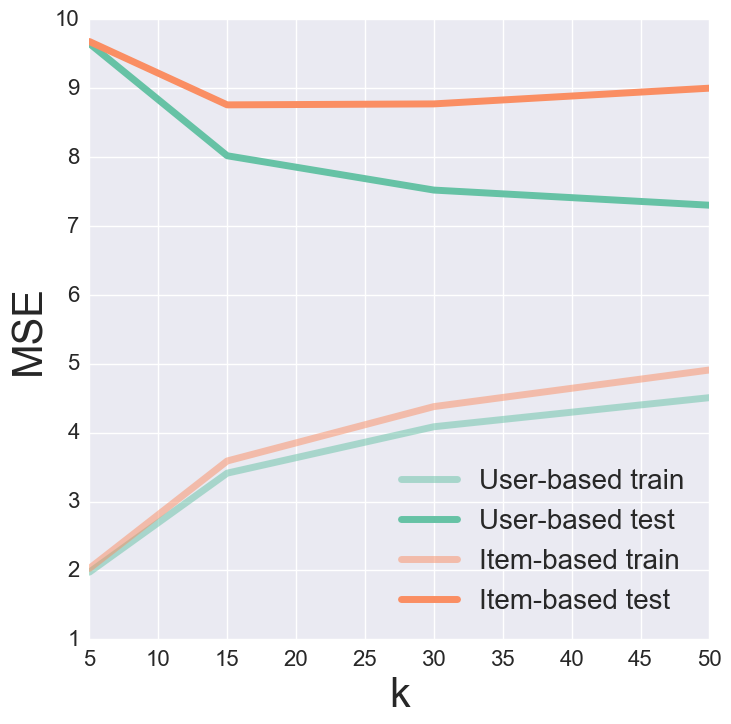

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

## Looks 15 is the best value to choose 